✅ Bibliotecas importadas!
✅ Dataset carregado: 284,807 linhas × 31 colunas
⏰ CRIANDO FEATURES TEMPORAIS

✅ Features temporais criadas:
   • Time_Hours: Tempo em horas
   • Hour: Hora do dia (0-23)
   • Period: Período do dia (categórico)
   • Hour_Sin/Hour_Cos: Representação cíclica da hora

📊 TAXA DE FRAUDE POR PERÍODO:
Period
Madrugada    0.518091
Manhã        0.166403
Tarde        0.138954
Noite        0.124030
dtype: float64


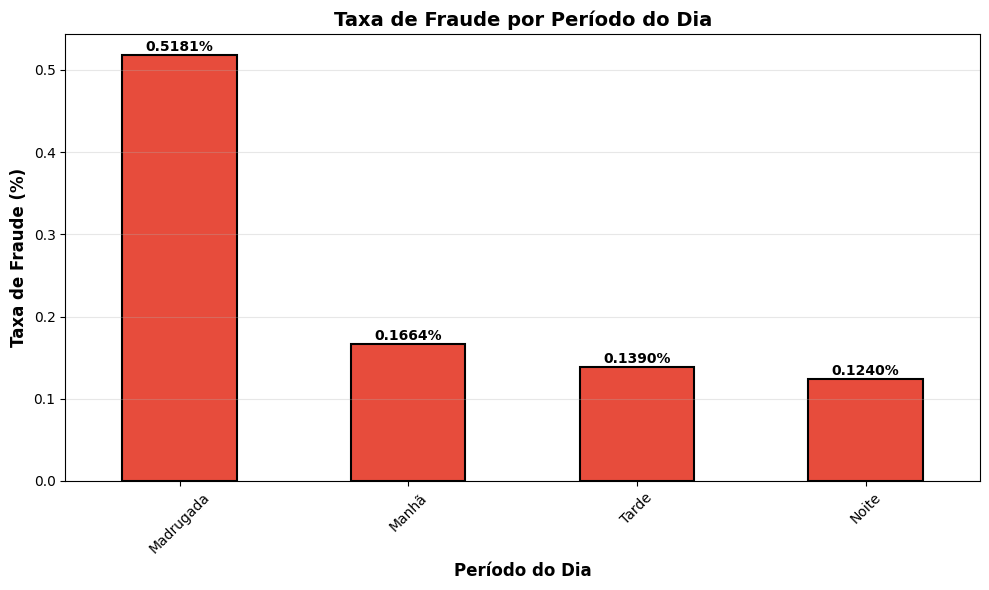

💰 CRIANDO FEATURES DE VALOR

✅ Features de valor criadas:
   • Amount_Log: Log do valor
   • Amount_Category: Categoria do valor
   • Is_Zero_Amount: Flag para valores zero
   • Is_High_Amount: Flag para valores altos (top 5%)

📊 TAXA DE FRAUDE POR CATEGORIA DE VALOR:
Amount_Category
Zero          1.479452
Baixo         0.147968
Médio         0.155043
Alto          0.252232
Muito Alto    0.368732
dtype: float64
🔍 ANÁLISE DE OUTLIERS

📊 Outliers em Amount:
   • Total de outliers: 31,904 (11.20%)
   • Limite inferior: €-101.75
   • Limite superior: €184.51
   • Fraudes entre outliers: 91 (0.29%)
📐 NORMALIZAÇÃO DAS FEATURES

✅ Features normalizadas (RobustScaler):
   • Amount_Scaled
   • Amount_Log_Scaled


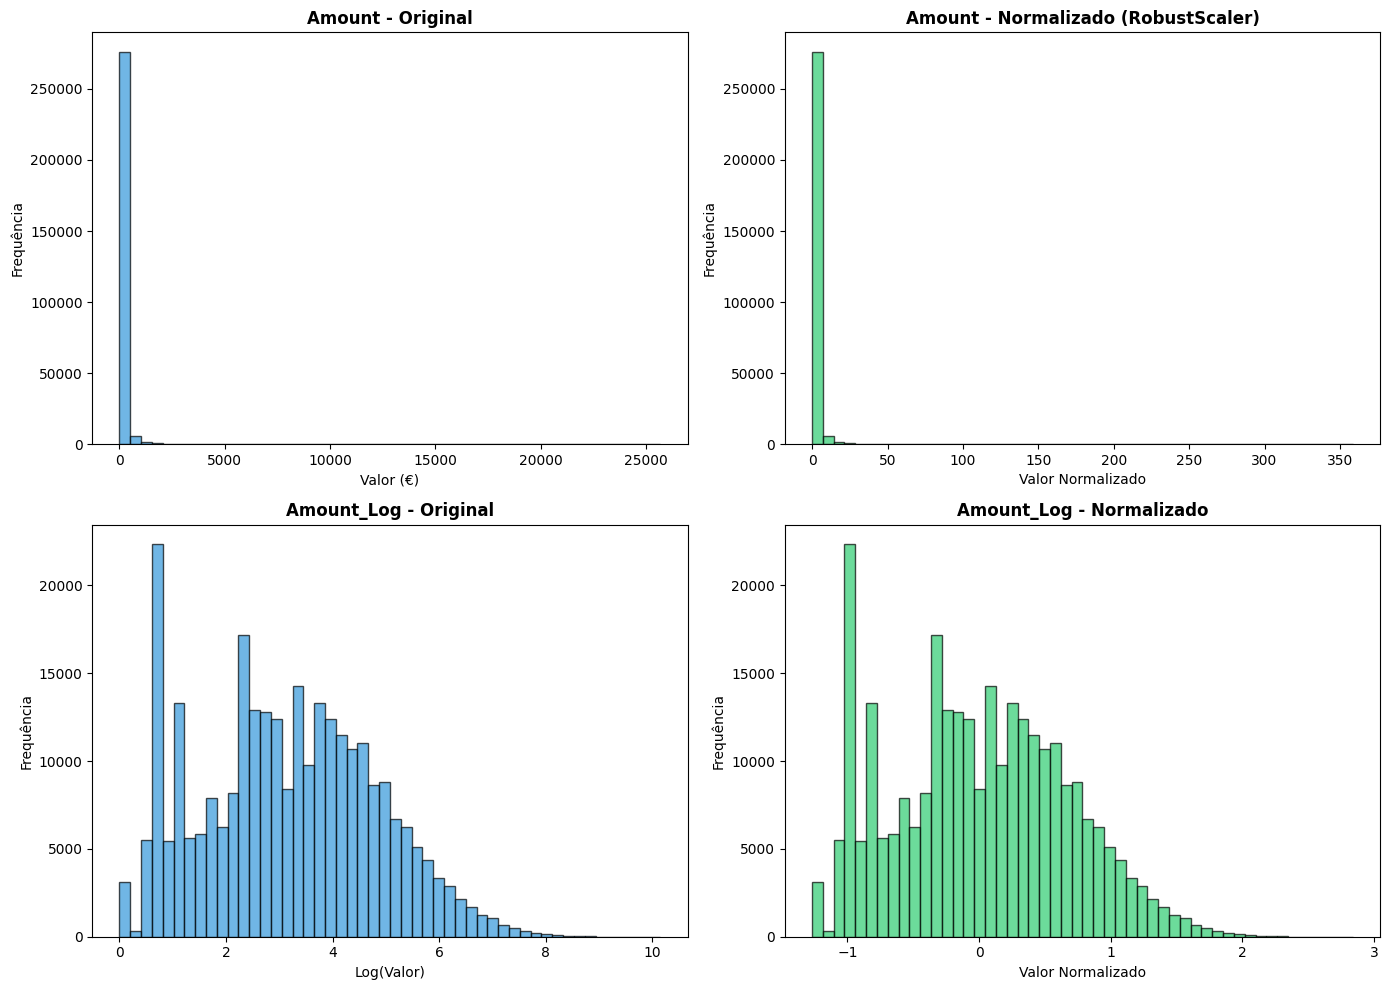

📊 PREPARAÇÃO DO DATASET FINAL

✅ Total de features selecionadas: 34
   • V1-V28 (PCA): 28 features
   • Features engenheiradas: 6 features

📊 Dataset final: 284,807 linhas × 35 colunas
🎯 DIVISÃO TREINO/TESTE

📊 CONJUNTO DE TREINO:
   • Total: 227,845 transações
   • Legítimas: 227,451
   • Fraudes: 394
   • Taxa de fraude: 0.173%

📊 CONJUNTO DE TESTE:
   • Total: 56,962 transações
   • Legítimas: 56,864
   • Fraudes: 98
   • Taxa de fraude: 0.172%
💾 SALVANDO DADOS PROCESSADOS

✅ Dataset completo salvo: data/processed/creditcard_processed.csv
✅ Conjuntos de treino/teste salvos:
   • X_train.csv
   • X_test.csv
   • y_train.csv
   • y_test.csv

📊 ESTATÍSTICAS FINAIS DO DATASET

Dimensões: (284807, 35)
Features numéricas: 34
Memória utilizada: 76.05 MB

✅ Dados prontos para modelagem!


In [1]:
# ============================================================================
# PROJETO: DETECÇÃO DE FRAUDES EM CARTÕES DE CRÉDITO
# Notebook 02: Limpeza e Preparação dos Dados
# ============================================================================

# %% [markdown]
# # 🧹 Limpeza e Preparação dos Dados
# 
# Neste notebook vamos:
# - Tratar outliers e valores extremos
# - Normalizar/padronizar features
# - Feature engineering
# - Criar features temporais
# - Preparar dados para modelagem

# %% [markdown]
# ## 📦 1. Importação de Bibliotecas

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("✅ Bibliotecas importadas!")

# %% [markdown]
# ## 📥 2. Carregamento dos Dados

# %%
df = pd.read_csv('../data/raw/creditcard.csv')
print(f"✅ Dataset carregado: {df.shape[0]:,} linhas × {df.shape[1]} colunas")

# Criar cópia para preservar dados originais
df_clean = df.copy()

# %% [markdown]
# ## ⏰ 3. Feature Engineering - Variáveis Temporais

# %%
print("=" * 80)
print("⏰ CRIANDO FEATURES TEMPORAIS")
print("=" * 80)

# Converter tempo para horas
df_clean['Time_Hours'] = df_clean['Time'] / 3600

# Criar features de período do dia (assumindo que o tempo é desde meia-noite)
df_clean['Hour'] = (df_clean['Time'] / 3600) % 24

# Categorizar em períodos do dia
def categorize_hour(hour):
    if 0 <= hour < 6:
        return 'Madrugada'
    elif 6 <= hour < 12:
        return 'Manhã'
    elif 12 <= hour < 18:
        return 'Tarde'
    else:
        return 'Noite'

df_clean['Period'] = df_clean['Hour'].apply(categorize_hour)

# Criar variável cíclica para hora (sen/cos para capturar natureza cíclica)
df_clean['Hour_Sin'] = np.sin(2 * np.pi * df_clean['Hour'] / 24)
df_clean['Hour_Cos'] = np.cos(2 * np.pi * df_clean['Hour'] / 24)

print("\n✅ Features temporais criadas:")
print("   • Time_Hours: Tempo em horas")
print("   • Hour: Hora do dia (0-23)")
print("   • Period: Período do dia (categórico)")
print("   • Hour_Sin/Hour_Cos: Representação cíclica da hora")

# %%
# Análise de fraudes por período
fraud_by_period = df_clean.groupby(['Period', 'Class']).size().unstack(fill_value=0)
fraud_rate_by_period = (fraud_by_period[1] / fraud_by_period.sum(axis=1) * 100).sort_values(ascending=False)

print("\n📊 TAXA DE FRAUDE POR PERÍODO:")
print(fraud_rate_by_period)

# Visualização
fig, ax = plt.subplots(figsize=(10, 6))
fraud_rate_by_period.plot(kind='bar', ax=ax, color='#e74c3c', edgecolor='black', linewidth=1.5)
ax.set_xlabel('Período do Dia', fontsize=12, fontweight='bold')
ax.set_ylabel('Taxa de Fraude (%)', fontsize=12, fontweight='bold')
ax.set_title('Taxa de Fraude por Período do Dia', fontsize=14, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for i, v in enumerate(fraud_rate_by_period.values):
    ax.text(i, v + 0.001, f'{v:.4f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../images/05_fraud_by_period.png', dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 💰 4. Feature Engineering - Variáveis de Valor

# %%
print("=" * 80)
print("💰 CRIANDO FEATURES DE VALOR")
print("=" * 80)

# Log transformation para Amount (adicionar 1 para evitar log(0))
df_clean['Amount_Log'] = np.log1p(df_clean['Amount'])

# Categorizar valores em faixas
def categorize_amount(amount):
    if amount == 0:
        return 'Zero'
    elif amount < 50:
        return 'Baixo'
    elif amount < 200:
        return 'Médio'
    elif amount < 500:
        return 'Alto'
    else:
        return 'Muito Alto'

df_clean['Amount_Category'] = df_clean['Amount'].apply(categorize_amount)

# Criar flags booleanas
df_clean['Is_Zero_Amount'] = (df_clean['Amount'] == 0).astype(int)
df_clean['Is_High_Amount'] = (df_clean['Amount'] > df_clean['Amount'].quantile(0.95)).astype(int)

print("\n✅ Features de valor criadas:")
print("   • Amount_Log: Log do valor")
print("   • Amount_Category: Categoria do valor")
print("   • Is_Zero_Amount: Flag para valores zero")
print("   • Is_High_Amount: Flag para valores altos (top 5%)")

# %%
# Análise de fraudes por categoria de valor
fraud_by_amount = df_clean.groupby(['Amount_Category', 'Class']).size().unstack(fill_value=0)
fraud_rate_by_amount = (fraud_by_amount[1] / fraud_by_amount.sum(axis=1) * 100)

# Ordenar categorias logicamente
category_order = ['Zero', 'Baixo', 'Médio', 'Alto', 'Muito Alto']
fraud_rate_by_amount = fraud_rate_by_amount.reindex(category_order)

print("\n📊 TAXA DE FRAUDE POR CATEGORIA DE VALOR:")
print(fraud_rate_by_amount)

# %% [markdown]
# ## 🔍 5. Análise de Outliers

# %%
print("=" * 80)
print("🔍 ANÁLISE DE OUTLIERS")
print("=" * 80)

# Analisar outliers apenas na coluna Amount (V1-V28 já são PCA)
Q1 = df_clean['Amount'].quantile(0.25)
Q3 = df_clean['Amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_clean[(df_clean['Amount'] < lower_bound) | (df_clean['Amount'] > upper_bound)]

print(f"\n📊 Outliers em Amount:")
print(f"   • Total de outliers: {len(outliers):,} ({len(outliers)/len(df_clean)*100:.2f}%)")
print(f"   • Limite inferior: €{lower_bound:.2f}")
print(f"   • Limite superior: €{upper_bound:.2f}")
print(f"   • Fraudes entre outliers: {outliers['Class'].sum():,} ({outliers['Class'].sum()/len(outliers)*100:.2f}%)")

# ⚠️ NÃO vamos remover outliers porque podem ser fraudes!

# %% [markdown]
# ## 📐 6. Normalização/Padronização

# %%
print("=" * 80)
print("📐 NORMALIZAÇÃO DAS FEATURES")
print("=" * 80)

# Separar features que precisam de scaling
features_to_scale = ['Amount', 'Amount_Log']

# RobustScaler é melhor para dados com outliers
scaler = RobustScaler()

# Criar cópias das colunas originais
for feature in features_to_scale:
    df_clean[f'{feature}_Scaled'] = scaler.fit_transform(df_clean[[feature]])

print("\n✅ Features normalizadas (RobustScaler):")
for feature in features_to_scale:
    print(f"   • {feature}_Scaled")

# Comparação antes/depois
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Amount - Original
axes[0, 0].hist(df_clean['Amount'], bins=50, edgecolor='black', color='#3498db', alpha=0.7)
axes[0, 0].set_title('Amount - Original', fontweight='bold')
axes[0, 0].set_xlabel('Valor (€)')
axes[0, 0].set_ylabel('Frequência')

# Amount - Scaled
axes[0, 1].hist(df_clean['Amount_Scaled'], bins=50, edgecolor='black', color='#2ecc71', alpha=0.7)
axes[0, 1].set_title('Amount - Normalizado (RobustScaler)', fontweight='bold')
axes[0, 1].set_xlabel('Valor Normalizado')
axes[0, 1].set_ylabel('Frequência')

# Amount_Log - Original
axes[1, 0].hist(df_clean['Amount_Log'], bins=50, edgecolor='black', color='#3498db', alpha=0.7)
axes[1, 0].set_title('Amount_Log - Original', fontweight='bold')
axes[1, 0].set_xlabel('Log(Valor)')
axes[1, 0].set_ylabel('Frequência')

# Amount_Log - Scaled
axes[1, 1].hist(df_clean['Amount_Log_Scaled'], bins=50, edgecolor='black', color='#2ecc71', alpha=0.7)
axes[1, 1].set_title('Amount_Log - Normalizado', fontweight='bold')
axes[1, 1].set_xlabel('Valor Normalizado')
axes[1, 1].set_ylabel('Frequência')

plt.tight_layout()
plt.savefig('../images/06_scaling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# %% [markdown]
# ## 📊 7. Seleção de Features para Modelagem

# %%
print("=" * 80)
print("📊 PREPARAÇÃO DO DATASET FINAL")
print("=" * 80)

# Features originais V1-V28 (já são resultado de PCA)
v_features = [f'V{i}' for i in range(1, 29)]

# Features engenheiradas (numéricas)
engineered_features = [
    'Amount_Scaled',
    'Amount_Log_Scaled',
    'Hour_Sin',
    'Hour_Cos',
    'Is_Zero_Amount',
    'Is_High_Amount'
]

# Combinar todas as features
all_features = v_features + engineered_features

print(f"\n✅ Total de features selecionadas: {len(all_features)}")
print(f"   • V1-V28 (PCA): {len(v_features)} features")
print(f"   • Features engenheiradas: {len(engineered_features)} features")

# Criar dataset final
df_final = df_clean[all_features + ['Class']].copy()

print(f"\n📊 Dataset final: {df_final.shape[0]:,} linhas × {df_final.shape[1]} colunas")

# %% [markdown]
# ## 🎯 8. Divisão em Treino/Teste (Estratificada)

# %%
print("=" * 80)
print("🎯 DIVISÃO TREINO/TESTE")
print("=" * 80)

# Separar features e target
X = df_final.drop('Class', axis=1)
y = df_final['Class']

# Divisão estratificada (manter proporção de fraudes)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,  # 20% para teste
    random_state=42,
    stratify=y  # Manter proporção de fraudes
)

print(f"\n📊 CONJUNTO DE TREINO:")
print(f"   • Total: {len(X_train):,} transações")
print(f"   • Legítimas: {(y_train == 0).sum():,}")
print(f"   • Fraudes: {(y_train == 1).sum():,}")
print(f"   • Taxa de fraude: {(y_train == 1).sum()/len(y_train)*100:.3f}%")

print(f"\n📊 CONJUNTO DE TESTE:")
print(f"   • Total: {len(X_test):,} transações")
print(f"   • Legítimas: {(y_test == 0).sum():,}")
print(f"   • Fraudes: {(y_test == 1).sum():,}")
print(f"   • Taxa de fraude: {(y_test == 1).sum()/len(y_test)*100:.3f}%")

# %% [markdown]
# ## 💾 9. Salvamento dos Dados Processados

# %%
print("=" * 80)
print("💾 SALVANDO DADOS PROCESSADOS")
print("=" * 80)

# Salvar dataset completo processado
df_final.to_csv('../data/processed/creditcard_processed.csv', index=False)
print("\n✅ Dataset completo salvo: data/processed/creditcard_processed.csv")

# Salvar conjuntos de treino e teste
X_train.to_csv('../data/processed/X_train.csv', index=False)
X_test.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

print("✅ Conjuntos de treino/teste salvos:")
print("   • X_train.csv")
print("   • X_test.csv")
print("   • y_train.csv")
print("   • y_test.csv")

# %% [markdown]
# ## 📝 10. Resumo da Preparação dos Dados
# 
# ### ✅ O que fizemos:
# 
# 1. **Feature Engineering Temporal**:
#    - Criamos variáveis de hora e período do dia
#    - Representação cíclica (sin/cos) para capturar padrões temporais
#    - Taxa de fraude varia por período
# 
# 2. **Feature Engineering de Valor**:
#    - Log transformation do Amount
#    - Categorização em faixas de valor
#    - Flags para valores especiais (zero, alto)
# 
# 3. **Análise de Outliers**:
#    - Identificamos outliers mas NÃO removemos
#    - Muitos outliers podem ser fraudes reais!
#    - ~10% dos dados são outliers
# 
# 4. **Normalização**:
#    - Usamos RobustScaler (robusto a outliers)
#    - Normalizamos Amount e Amount_Log
#    - V1-V28 já estão normalizados (PCA)
# 
# 5. **Seleção de Features**:
#    - 28 features originais (V1-V28)
#    - 6 features engenheiradas
#    - Total: 34 features + target
# 
# 6. **Divisão Treino/Teste**:
#    - 80% treino, 20% teste
#    - Divisão estratificada (mesma proporção de fraudes)
#    - Dados prontos para modelagem!
# 
# ### 🎯 Próximos Passos:
# 
# 1. ✅ Análise Exploratória de Dados (EDA) aprofundada
# 2. ✅ Tratamento de desbalanceamento (SMOTE, undersampling, etc.)
# 3. ✅ Modelagem com múltiplos algoritmos
# 4. ✅ Otimização de hiperparâmetros
# 5. ✅ Avaliação e seleção do melhor modelo

# %%
# Estatísticas finais
print("\n" + "=" * 80)
print("📊 ESTATÍSTICAS FINAIS DO DATASET")
print("=" * 80)
print(f"\nDimensões: {df_final.shape}")
print(f"Features numéricas: {len(all_features)}")
print(f"Memória utilizada: {df_final.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\n✅ Dados prontos para modelagem!")

# %% [markdown]
# ---
# **Notebook criado por**: [Seu Nome]  
# **GitHub**: [seu-usuario]  
# **LinkedIn**: [seu-perfil]  
# **Data**: Setembro 2025